<img src="escudo_utfsm.gif" style="float:right;height:100px">
<img src="IsotipoDIisocolor.png" style="float:left;height:100px">
<center>
    <h1> ILI285 - Computación Científica I / INF285 - Computación Científica</h1>
    <h1> Tarea 4: PageRank y GMRes </h1> 
    <h3> [S]cientific [C]omputing [T]eam 2019</h3>
</center>
<p>
<center>Julio 2019 - v1.3 </center>
</p>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy as sp
from ipywidgets import interact, IntSlider
#if not instaled: pip3 install networkx
import networkx as nx

## Contexto

Con el rápido crecimiento de internet, los motores de búsqueda en la web se han convertido en importantes herramientas para obtener información. Google es uno de los más exitosos y populares sistemas en estos años, dado su simple algoritmo, [PageRank](https://en.wikipedia.org/wiki/PageRank), el cual fue propuesto por _Larry Page_ y _Sergey Brin_. PageRank busca asignar de forma numérica la relevancia de las páginas web basándose en la cantidad de los enlaces que apuntan hacia ella.

En esta tarea se utilizará el algoritmo de PageRank para encontrar páginas web relevantes a partir de información relaciones entre los links o enlaces entre varias páginas.

## PageRank

Para poder trabajar con el algoritmo, es necesario considerar inicialmente una matriz de adyacencia $A \in \mathbb{R}^{n \times n}$, con $n$ la cantidad de páginas web. Las entradas $a_{ij}$ de esta matriz tienen el valor 1 si la página $i$ tiene un enlace a la página $j$ y 0 en caso contrario. Notar que no necesariamente la matriz $A$ es simétrica, lo que denota que dos páginas web distintas podrían no enlazarse mutuamente. Además, considere que una misma página no se enlazará consigo misma, por lo que la matriz tendrá cero en su diagonal principal. 

Adicionalmente, podrían darse casos de que existan páginas que solo tienen links hacia ellas, pero no tienen links hacia otras páginas. En una representación de la matriz de adyacencia como grafo, se le conoce a estas páginas como nodos _sumideros_. Una consecuencia de estos casos podía ser que usuarios que llegan a esas páginas quedan retenidos porque no existen links a los cuales seguir navegando. Para evitar esta situación, se agregará la perturbación _rank-one_ a la matriz de adyacencia $A$.

$$
    \tilde{A} = A + \mathbf{a}\cdot\mathbf{1}^T,
$$

donde $\mathbf{a} \in \mathbb{R}^{n}$ es un vector con un $1$ en la componente que corresponde a los nodos sumideros  y $0$ en los otras componentes, el vector $\mathbf{1}$ corresponde al vector de unos en $\mathbb{R}^{n}$ y $^T$ es el operador transpuesta.


Considere la siguiente matriz de adyacencia que muestra la relación entre 5 páginas web.

$$
A = \begin{bmatrix}
0 & 1 & 1 & 0 & 0\\
0 & 0 & 1 & 1 & 0\\
1 & 1 & 0 & 1 & 1\\
0 & 0 & 0 & 0 & 0\\
1 & 0 & 1 & 1 & 0\\
\end{bmatrix}
$$

In [2]:
#generacion de una matriz aleatoria
np.random.seed(2564)
A = np.random.randint(2, size=(5,5))
#eliminar diagonales en caso de existir alguna
np.fill_diagonal(A,0)
print(A)

[[0 1 1 0 0]
 [0 0 1 1 0]
 [1 1 0 1 1]
 [0 0 0 0 0]
 [1 0 1 1 0]]


In [3]:
def draw_adjacency_matrix(A):
    n = A.shape[0]
    G = nx.DiGraph()
    edges = list()
    for i in range(n):
        for j in range(n):
            if A[i,j] > 0:
                edges.append((i,j))
    G.add_nodes_from(range(n))
    G.add_edges_from(edges)
    nx.draw(G, with_labels=True, font_weight='bold', arrows=True, arrowsize = 30, alpha=0.5)
    plt.show()

La matriz puede ser visualizada en forma de gráfo dirigido con la función `draw_adjacency_matrix(A)`

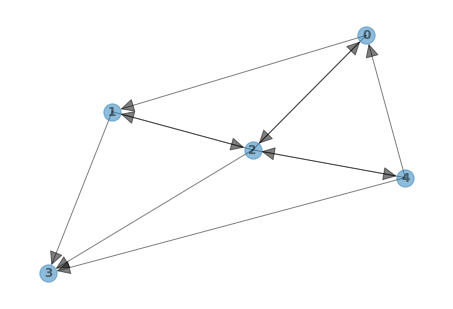

In [4]:
draw_adjacency_matrix(A)

En este caso el nodo 3 es un nodo _sumidero_ por lo que agregando la perturbación mostrada anteriormente, la matriz $\tilde{A}$ quedaría como:

$$
\tilde{A} = \begin{bmatrix}
0 & 1 & 1 & 0 & 0\\
0 & 0 & 1 & 1 & 0\\
1 & 1 & 0 & 1 & 1\\
1 & 1 & 1 & 1 & 1\\
1 & 0 & 1 & 1 & 0\\
\end{bmatrix}
$$

In [5]:
A_tilde = A + np.outer(np.array([0,0,0,1,0]),np.ones(5))
print(A_tilde)

[[0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0.]]


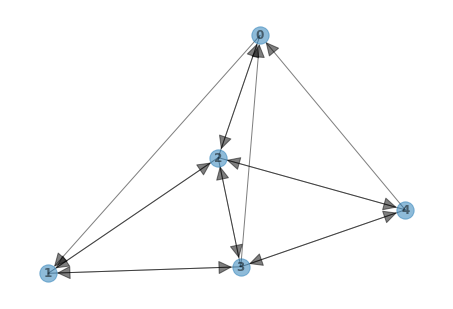

In [6]:
draw_adjacency_matrix(A_tilde)

Una vez establecida la matriz de adyacencia (con perturbaciones si aplica), dos fenómenos deben considerarse:

**1.** Considere que las páginas son navegadas al azar, en un proceso llamado _random walk_. Esto es, que una página $j$ puede ser accedida por cualquier otra página $i$ que posea un enlace hacia ella con la misma probabilidad. Sea $p_{ij}$ la probabilidad de visitar la página $j$ a partir de $i$. Cada valor de $p_{ij}$ corresponde a las entradas de una matriz de transición $P$, la cual es **estocástica por filas**, esto es, que todas sus filas cumplen la propiedad de que la suma de sus valores es igual a 1. De acuerdo al ejemplo anterior, la matriz $P$ se obtiene dividiendo cada fila por la suma de sus valores:

$$
P = \begin{bmatrix}
0   & 1/2 & 1/2 & 0   & 0\\
0   & 0   & 1/2 & 1/2 & 0\\
1/4 & 1/4 & 0   & 1/4 & 1/4\\
1/5 & 1/5 & 1/5 & 1/5 & 1/5\\
1/3 & 0   & 1/3 & 1/3 & 0\\
\end{bmatrix}
$$

**2.** Se debe considerar, además del _random walk_, el evento aleatorio de saltar desde una página $i$ a cualquier otra página no necesariamente adyacente en el grafo. Este comportamiento es el _random jump_ o _teleport_, y le es asociado a un vector $\mathbf{v} \in \mathbb{R}^n$, tal que $\mathbf{v} = \mathbf{e}/n$, $\mathbf{e} = \begin{bmatrix}1 & 1 & \ldots & 1 & 1 \end{bmatrix}^T$ es un vector de unos que asigna la misma ponderación de probabilidad de _salto_ a todas las $n$ páginas en el grafo.

Se define $G \in \mathbb{R}^{n \times n}$ la **Matriz de Google** que considera los dos fenómenos descritos anteriormente, donde se ha incorporado un factor de amortiguamiento (_damping factor_) $\alpha$.

$$
G = \alpha\,P^T + (1-\alpha)\,\mathbf{v}\mathbf{e}^T
$$

La matriz $G$ es estocástica por columnas y tiene la propiedad de que su mayor valor propio en magnitud, que se conoce como valor propio dominante, es igual a 1. El cálculo de PageRank consiste en determinar el vector propio $\mathbf{x}$ que está asociado a este valor propio dominante, es decir: 

$$
\mathbf{x} = G\,\mathbf{x}
$$

El vector propio $\mathbf{x}$ puede normalizarse (debido a que cualquier múltiplo de $\mathbf{x}$ también es vector propio), de tal forma que los valores de este vector representan probabilidades. Al considerar las probabilidades, de mayor a menor, se establece un ranking de páginas que serán mostradas por el motor de búsqueda de Google. 

Usualmente, se pueden utilizar métodos numéricos que estimen este vector $\mathbf{x}$, pero suelen ser costosos y converger muy lento. Es por esto, que una versión alternativa para encontrar PageRank considera resolver un sistema de ecuaciones. Combinando las ecuaciones anteriores y reordenando se tiene que:

$$
\begin{aligned}
\mathbf{x} &= \left( \alpha\,P^T + (1-\alpha)\,\mathbf{v}\mathbf{e}^T \right)\,\mathbf{x}\\
\mathbf{x}-\alpha\,P^T\,\mathbf{x} &= (1-\alpha)\,\mathbf{v}\mathbf{e}^T\mathbf{x}\\
\end{aligned}
$$

Debido a que $\mathbf{x}$ está normalizado, $\mathbf{e}^T\mathbf{x} = 1$ y se debe resolver el siguiente sistema lineal:

$$
\begin{aligned}
(I-\alpha\,P^T)\mathbf{x} &= (1-\alpha)\,\mathbf{v}\\
\widehat{A}\,\mathbf{x} &= \widehat{\mathbf{b}}
\end{aligned}
$$

En el cual, la matriz $\widehat{A} \in \mathbb{R}^{n \times n}$ es una matriz dispersa, no necesariamente simétrica y $\widehat{\mathbf{b}} \in \mathbb{R}^n$. Debido a las propiedades de la matriz $\widehat{A}$, en esta tarea se estudiará el uso de GMRes para resolver este tipo de sistemas lineales. Para poder interpretar las soluciones de PageRank como probabilidades, el vector de soluciones $\mathbf{x}$ debe normalizarse de manera que sus elementos sumen 1, i.e, $\mathbf{\tilde{x}} = \mathbf{x}/\|\mathbf{x}\|_1$.

### Datasets

Considere los datasets de los archivos `adjacency1.dat`, `adjacency2.dat`, `adjacency3.dat` y `adjacency4.dat`, que representan matrices de adyacencia tales que:
- Adjacency1 es una matriz de adyacencia de 100 páginas y alrededor de un 20% de elementos no nulos.
- Adjacency2 es una matriz de adyacencia de 100 páginas y alrededor de un 50% de elementos no nulos.
- Adjacency3 es una matriz de adyacencia de 100 páginas y alrededor de un 80% de elementos no nulos.
- Adjacency4 es una matriz de adyacencia de 1000 páginas y alrededor de un 5% de elementos no nulos.

Cada fila $i$ de un archivo dataset corresponde a una página de índice $i$, y todos los valores separados por espacios en dicha fila representan los índices de las páginas $j$ a las cuales $i$ apunta. En otras palabras, un archivo dataset registra los vértices del grafo de adyacencia.

Considere la siguiente función,`read_adjacency_matrix` , que obtiene la matriz de adyacencia a partir de los archivos anteriores.

In [7]:
'''
Input:
filename - (string) name of adjacency matrix file
Output: 
A - (n x n matrix) adjacency matrix
'''
def read_adjacency_matrix(file_path):
    adjacency_list = []
    with open(file_path, 'r') as f:
        for line in f:
            adjacency_list.append(np.array(list(map(int, line.split()))))
    n = len(adjacency_list)
    A = np.zeros((n,n))
    for i in range(n):
        A[i, adjacency_list[i]] = 1
    return A

In [8]:
A = read_adjacency_matrix("adjacency1.dat")
print(A)

[[0. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 0.]]


Considere además, el dataset `web-NotreDame` un dataset compuesto por 325729 páginas y 1497134 links entre ellas y el dataset `web-Stanford` compuesto por 281903 páginas y 2312497 links. Estos datasets se encuentran disponibles en los siguientes links. 

- <a href="http://snap.stanford.edu/data/web-NotreDame.html"> Dataset NotreDame</a> [2]
- <a href="http://snap.stanford.edu/data/web-Stanford.html">Dataset Stanford</a> [3]

## Sección 1 (30 puntos): Comparación de soluciones con GMRes y PALU

En esta sección se compararán las soluciones de PageRank obtenidas por medio de GMRes y PALU. Para esto, se considerarán los datasets de los archivos `adjacency1.dat`, `adjacency2.dat`, `adjacency3.dat` y `adjacency4.dat`, variaciones en el _damping factor_ $\alpha$ y el número de iteraciones $k$ de GMRes.

**1.** Construya el sistema lineal necesario para encontrar PageRank. Para ello desarrolle la función `build_linear_system`, que recibe una matriz de adyacencia $A$ y un _damping factor_ $\alpha$.

```python
'''
Input:
A - (n x n matrix) adjacency matrix
alpha - (float) damping factor, takes values from 0 to 1
Output: 
A_hat - (n x n matrix) matrix of linear system
b_hat - (n vector) right hand side vector of linear system
'''
def build_linear_system(A, alpha):
    ...
    return A_hat, b_hat
```

In [9]:
def build_linear_system(A, alpha):
    #your code goes here!
    return A_hat, b_hat

**2.** Considere el error $e_k = \|\mathbf{x^{k}_{G}}-\mathbf{x_{P}}\|_2$ una métrica de error que compara $\mathbf{x_{P}}$, la solución de PageRank obtenida por PALU, con $\mathbf{x^{k}_{G}}$ la solución de PageRank obtenida con $k$ iteraciones de GMRes. Construya un gráfico que muestre $e_k$ versus $k$ y utilice un widget para seleccionar un dataset y variar el valor del _damping factor_ $\alpha$. ¿Qué puede decir de la información mostrada en el gráfico? ¿Cómo afecta $\alpha$ en los resultados obtenidos?

## Sección 2 (30 puntos): Tiempo de Ejecución

En esta sección se compararán los tiempos de ejecución de GMRes y PALU necesarios para resolver los sistemas de ecuaciones de PageRank. Para esto, se considerarán los datasets de los archivos `adjacency1.dat`, `adjacency2.dat`, `adjacency3.dat` y `adjacency4.dat`, variaciones en el _damping factor_ $\alpha$ y el número de iteraciones $k$ de GMRes.

**1.** Analice efecto de variar _damping factor_ $\alpha$ para encontrar las 10 primeras páginas entregadas por PageRank. Para ello utilice la función `get_damping_ranking` definida a continuación. 

```python
'''
Input:
A - (n x n matrix) adjacency matrix
alpha - (float) damping factor, takes values from 0 to 1
k - number of iterations of GMRes until return a solution, use only if method is 'GMRes'
method - string that indicates the method used to solve the linear system. Take values 'PALU' or 'GMRes'
Output: 
ranking - list with 10 pages of ranking sorted by largest probability
'''
def get_damping_ranking(A, alpha, k, method='GMRes'):
    ...
    return ranking
```

In [10]:
def get_damping_ranking(A, alpha, k, method='GMRes'):
    #your code goes here!
    ranking = 10*[np.nan] #you have to modify this
    return ranking

**2.** Construya un gráfico que muestre el tiempo de ejecución para determinar el ranking versus el factor de amortiguamiento $\alpha$. En el mismo gráfico debe mostrar los dos métodos utilizados (GMRes y PALU). Además, utilice un widget que permita seleccionar uno de los cuatro datasets mencionados y el número $k$ de iteraciones de GMRes. ¿Qué puede decir respecto de los resultados obtenidos en cada método al variar el valor de $\alpha$?

## Sección 3 (40 puntos): Análisis de iteraciones de GMRes

En esta sección debe analizar las soluciones obtenidas por GMRes en cada iteración, utilizando los datasets `web-NotreDame` y `web-Stanford`. Se recomienda modificar el código de GMRes de los Jupyter Notebook del curso, aunque no es obligatorio. **Importante:** Debido al tamaño de estos datasets, no se debe intentar cargar toda la matriz de adyacencia en memoria en formato denso.

Considere la relación error $e_{k}$ versus iteración $k$, donde el error puede ser definido de la siguiente manera:

$$
e_{k} = \| \mathbf{x}_{k}-\mathbf{x}_{k-1} \|_2
$$

   Donde $\mathbf{x}_k$ es la solución de GMRes obtenida en la iteración $k$-ésima, con $k$ que **puede tomar valores** en el rango $[1, 2, \ldots, m]$. y $m$ el número de páginas del dataset. 
   
**1.** Utilice GMRes de manera conveniente para graficar el error $e_k$ versus $k$, utilizando un widget para variar el _damping factor_ $\alpha$ y seleccionar uno de los dos datasets requeridos. ¿Qué puede decir del error a medida que $k$ aumenta? ¿En qué afecta el valor de $\alpha$?

**Recomendación:** no intente cargar toda la matriz $\widehat{A}$ en memoria. En lugar de eso, considere que debido a que $\widehat{A}$ es _sparse_, la matriz $P$ también lo es y evite el cálculo de productos exteriores explícitamente. Se recomienda revisar el módulo `sparse` de `scipy` [4]. Puede recurrir a modificaciones de GMRes para desarrollar esta pregunta. Utilice un valor máximo de $k$ razonable, pero no muy pequeño. No debe llegar necesariamente a $k = m$. Justifique su elección apropiadamente.

## Sección 4 (10 puntos): Conclusiones

A partir de lo desarrollado en esta tarea concluya acerca de la pertinencia de utilizar GMRes para encontrar PageRank. ¿Qué ventajas y desventajas tiene el uso de este método en este problema? Comente.

---
# Instrucciones:

* **Importante, Asegúrese de responder TODO lo que la pregunta pide.**
* La estructura de la tarea es la siguiente:
     1. Título, nombre de estudiante, email y rol.
     2. Responder cada pregunta de forma personal.
     5. Referencias. Es muy importante incluir todas las fuentes usadas, de otra forma se considera que lo no se ha citado adecuadamente es su trabajo.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`) entregado.
* Recuerde responder la encuesta en el plazo establecido
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, `Matplotlib` y `ipywidgets`, entre otras, así como la **correcta implementación de algoritmos vectorizados**.
* **MUY IMPORTANTE** El archivo de entrega debe denominarse TareaN-rol.tar.gz y _notebook_ debe tener como nombre TareaN-rol.ipynb, donde $N$ es el número de la tarea y debe contener un directorio con todos los archivos necesarios para ejecutar el notebook, junto con un archivo README indicando explícitamente las librerías o módulos utilizados, nombre y rol del estudiante. Por cada error en este ambito implicará un descuento de 30 puntos.
* El descuento por día de atraso será de $30$ puntos, con un máximo de 1 día de atraso. No se recibirán entregas después de este día.
* Debe citar toda fuente de código externo. 
* El trabajo es personal, no se permite compartir código ni utilizar código de otros, aunque sí se sugiere discutir aspectos generales con sus compañeros.
* En caso de sospecha de no cumplimiento de estas instrucciones, se solicitará al involucrado o la involucrada a aclarar la situación. Dependiendo de la justificación se decidirá su calificación, la cual podrá o no ser penalizada.
* El no seguir estas instrucciones, implica descuentos en su nota obtenida.

---

# Referencias


[1] PageRank, https://en.wikipedia.org/wiki/PageRank

[2] R. Albert, H. Jeong, A.-L. Barabasi. Diameter of the World-Wide Web. Nature, 1999.

[3] J. Leskovec, K. Lang, A. Dasgupta, M. Mahoney. Community Structure in Large Networks: Natural Cluster Sizes and the Absence of Large Well-Defined Clusters. Internet Mathematics 6(1) 29--123, 2009.

[4] Sparse matrices, https://docs.scipy.org/doc/scipy/reference/sparse.html